In [7]:
import sys
sys.path.append("../")

In [8]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask, reshape_scalar_predictand, reshape_multiday_predictand
import xarray as xr
#Creating a Dask local cluster for parallel computing (making the computations later on much faster)
from dask.distributed import Client, LocalCluster


In [9]:
#HYPERPARAMETERS
days_intake_length = 90
forecast_day = 30


#LIBRARY IMPORTS
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
#cluster = LocalCluster()  # n_workers=10, threads_per_worker=1,
client = Client(processes=False)


In [10]:
#This will tell you where you dashboard will be so you can visualize your model being run
print(client.scheduler_info()['services'])

{'dashboard': 8787}


In [43]:
#Loading the transformed dataset
#glofas_loaded = xr.open_dataset("/tmp/flood_prediction/pipeline/data_download:upload/reshaped_glofas_2019.nc")
glofas_loaded = xr.open_dataset("./glofas_masked_elbe_1999-2005.nc")

In [12]:
era5_loaded = xr.open_mfdataset("/mnt/bucket/stuarts_files/Elbe/reanalysis-era5-single-levels_convective_precipitation,land_sea_mask,large_scale_precipitation,runoff,slope_of_sub_gridscale_orography,soil_type,total_column_water_vapour,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2_*.nc", combine="by_coords")

In [13]:
era5_loaded

<xarray.Dataset>
Dimensions:    (latitude: 25, longitude: 33, time: 180367)
Coordinates:
  * latitude   (latitude) float32 54.0 53.75 53.5 53.25 ... 48.5 48.25 48.0
  * longitude  (longitude) float32 9.0 9.25 9.5 9.75 ... 16.25 16.5 16.75 17.0
  * time       (time) datetime64[ns] 1999-01-01 ... 2019-11-29T06:00:00
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    lsp        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    slor       (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    slt        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 33), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-02 16:58:32 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [14]:
era5 = era5_loaded.copy()

In [44]:
glofas_loaded

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 2557)
Coordinates:
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2005-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Oct 10 12:28:51 2019: cdo -seldate,1999-01...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.6 (http://m...

In [47]:
y_orig = glofas_loaded
#Making a copy because y will be transformed to represent the variation of discharge. The model will be predicting the variation of discharge, not the quantity of discharge itself
y = y_orig

#Era5 will be the predictor dataset


In [21]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


In [25]:
elbe_basin_mask = get_basin_mask(glofas_loaded['dis24'].isel(time=0), 'Elbe')

In [26]:
#Reshape to align in coordinates
era5_masked = era5.loc[period_train].interp(latitude=y.latitude, longitude=y.longitude).where(elbe_basin_mask, drop=True)
X = era5_masked


#Downsampling our time from hourly to daily
X = X.resample(time='1D').mean()


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/8 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/9 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/10 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/11 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/12 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/13 remote=inproc://172.31.1.197/18502/1>
distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://172.31.1.197/18502/14 remote=inproc://17

In [45]:
X

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 2557)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2005-12-31
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    lsp        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    slor       (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    slt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(1, 54, 71), meta=np.ndarray>

In [48]:
y

<xarray.Dataset>
Dimensions:    (latitude: 54, longitude: 71, time: 2557)
Coordinates:
  * latitude   (latitude) float64 53.85 53.75 53.65 53.55 ... 48.75 48.65 48.55
  * longitude  (longitude) float64 9.25 9.35 9.45 9.55 ... 16.05 16.15 16.25
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2005-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Oct 10 12:28:51 2019: cdo -seldate,1999-01...
    cdo_openmp_thread_number:  8
    NCO:                       netCDF Operators version 4.7.8 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.6 (http://m...

In [ ]:
# #Reshape to align in time
# from tqdm import tqdm
# for i in tqdm(range(0, len(X.latitude))):

#     for j in range(0, len(X.longitude)):
        
#         if i==0 and j==0:
#             Xda = X.isel(latitude=i, longitude=j).to_array(dim='features').T
# #             yda = y.isel(latitude=i, longitude=j).to_array(dim='features').T
            
#         else:
#             XdaNew = X.isel(latitude=i, longitude=j).to_array(dim='features').T
# #             ydaNew = y.isel(latitude=i, longitude=j).to_array(dim='features').T

#             Xda = xr.concat([Xda, XdaNew], 'points')
# #             yda = xr.concat([yda, ydaNew], 'points')
            



In [49]:
X_mean = X.mean(['latitude','longitude'])

In [50]:
y_mean = y.mean(['latitude','longitude'])

In [58]:
Xda = X_mean.to_array(dim='features').T
yda = y_mean['dis24']

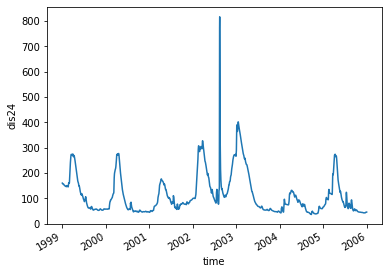

In [59]:
yda.plot()

In [60]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]


In [61]:
X_train

<xarray.DataArray 'stack-5b855bbe4201f8ca7c87ae637b2c80ac' (time: 2557, features: 9)>
dask.array<transpose, shape=(2557, 9), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2005-12-31
  * features  (features) <U5 'cp' 'lsm' 'lsp' 'ro' ... 'tcwv' 'swvl1' 'swvl2'

In [62]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
# sc2 = MinMaxScaler(feature_range=(0,1))
# y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))
X_train = []
y_train_array = []

#Temporary fix
y_train_scaled = y_train

/root/miniconda3/envs/main/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/root/miniconda3/envs/main/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/root/miniconda3/envs/main/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [71]:
y_train_scaled.shape

(2557,)

In [115]:
X_train = []

In [116]:
y_train_array = []

In [117]:
#Iterating through each feature, shifting the time for each feature, and appending the time-shifted feature array to X_train for a total of 16 times
for n in range(9):
    feature_array = []

    for i in range(days_intake_length, len(X_train_scaled)-forecast_day):
        feature_array.append(X_train_scaled[i - days_intake_length:i, n])


    X_train.append(feature_array)

y_feature_array = []

for i in range(days_intake_length, len(y_train_scaled)-forecast_day):
    y_feature_array.append(y_train_scaled[i-days_intake_length:i])

X_train.append(y_feature_array)



In [96]:
np.array(X_train).shape

(10, 2467, 90)

In [118]:

#Creating the transformed y_train array which is shifted by 60 days
for i in range(days_intake_length, len(y_train_scaled)-forecast_day):
    y_train_array.append(y_train_scaled.values[i: i + forecast_day])

#Transforming the list into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train_array)

X_train.shape
# (17, 8862, 60)

#Reshaping new_X_train to be supported as an input format for the LSTM
X_train = np.reshape(X_train, (X_train.shape[1], X_train.shape[2], X_train.shape[0]))
X_train.shape



(2437, 90, 10)

In [119]:
y_train.shape

(2437, 30)

In [120]:
#LSTM MODEL
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=800, return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2]))) #(n_timesteps, n_features)#(n_sample, n_timesteps, n_features)
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=800))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=30))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
training_history = regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
2437/2437 [==============================] - 562s 230ms/step - loss: 13064.9041
Epoch 2/100
2437/2437 [==============================] - 537s 221ms/step - loss: 7740.7262
Epoch 3/100
2437/2437 [==============================] - 522s 214ms/step - loss: 6547.4818
Epoch 4/100
2437/2437 [==============================] - 522s 214ms/step - loss: 6403.4210
Epoch 5/100
2437/2437 [==============================] - 522s 214ms/step - loss: 6397.6346
Epoch 6/100
2437/2437 [==============================] - 527s 216ms/step - loss: 6395.4849
Epoch 7/100
2437/2437 [==============================] - 528s 217ms/step - loss: 6391.8850
Epoch 8/100
2437/2437 [==============================] - 522s 214ms/step - loss: 6393.1031
Epoch 9/100
2437/2437 [==============================] - 530s 217ms/step - loss: 6396.7812
Epoch 10/100
2437/2437 [==============================] - 532s 218ms/step - loss: 6386.1113
Epoch 11/100
2437/2437 [==============================] - 532s 218ms/step - loss: 6391.0

In [ ]:
#SAVING THE MODEL
# serialize model to YML
regressor_yaml = regressor.to_yaml()
with open("./elbe_model.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("./elbe_model.h5")
#Seialize feature scaling weights

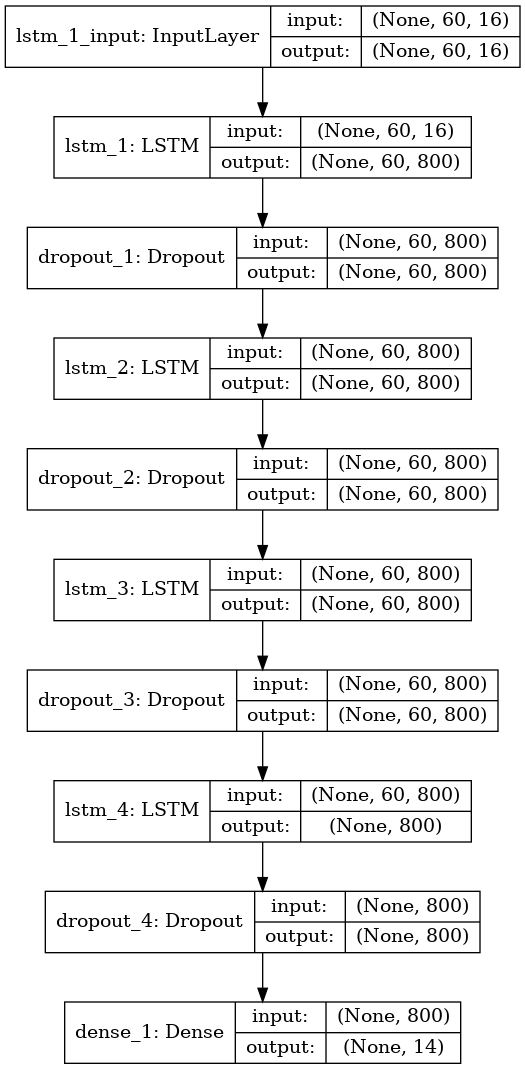

In [2]:
from keras.utils import plot_model
import pydot

plot_model(regressor, to_file='../images/Elbe/model.png', show_shapes=True)

In [ ]:
#TODO: Add error bar from code
#Visualizing the loss functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(training_history['loss'], label='loss')
ax.plot(training_history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')